# **Test A/B**

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

## Descripción técnica

- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000


In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans


In [3]:
# Leer los archivos CSV y asignarles nombres

marketing_eventos = pd.read_csv('/home/dilcia/Documentos/Proyectos Data Analist/data-analysis/Sprint-14/ab_project_marketing_events_us.csv')
eventos = pd.read_csv('/home/dilcia/Documentos/Proyectos Data Analist/data-analysis/Sprint-14/final_ab_events_upd_us.csv')
usuarios = pd.read_csv('/home/dilcia/Documentos/Proyectos Data Analist/data-analysis/Sprint-14/final_ab_new_users_upd_us.csv')
participantes_test = pd.read_csv('/home/dilcia/Documentos/Proyectos Data Analist/data-analysis/Sprint-14/final_ab_participants_upd_us.csv')



## **Etapas del Proyecto**

### 1. **Preprocesamiento de Datos**

Objetivo: Cargar, limpiar y preparar los datos para el análisis.

- ¿Es necesario convertir los tipos?
- ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?

### 2. **Análisis Exploratorio de Datos (EDA)**

Objetivo: Entender la conversión y distribución de los nuevos cambios relacionados con el nuevo sistema de recomendaciones.
    
- Estudia la conversión en las diferentes etapas del embudo.
- ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?
- ¿Hay usuarios que están presentes en ambas muestras?
- ¿Cómo se distribuye el número de eventos entre los días?
- ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?
    

### 3. **Hipótesis a Evaluar**

Objetivo: Validar si las diferencias entre son estadísticamente significativas entre el grupo A y B.
 
- ¿Qué puedes decir sobre los resultados de la prueba A/B?
- Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones

### 4. **Conclusiones**

- Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B


# 1. Preprocesamiento de Datos

In [4]:
display(marketing_eventos)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [5]:
marketing_eventos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


In [6]:
# Verificar valores ausentes

display(marketing_eventos.isnull().sum())

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [7]:
# Verificando si hay duplicados

marketing_eventos.duplicated(keep=False).sum()

np.int64(0)

In [8]:
display(eventos)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [9]:
eventos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [10]:
# Evaluando los tipos de eventos de mi dataframe

eventos['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [11]:
# Evaluando que todos los eventos diferentes a compra tienen valores ausentes en details

eventos[eventos['event_name'] != 'purchase'].isna().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

#### **Comentario:** 

- Evaluando que todos los eventos diferentes a compra tienen valores ausentes en details lo cual es correcto para el proceso, son pagos en USD para el evento purchase.

In [12]:
# Reemplazaremos por 0 nuestros NaN

eventos['details'] = eventos['details'].fillna(0)


In [13]:
# Evaluando si se reemplazaron los valores ausentes

eventos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     423761 non-null  float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [14]:
#Verificando si hay duplicados

eventos.duplicated(keep=False).sum()

np.int64(0)

In [15]:
display(usuarios)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
117402,1DB53B933257165D,2020-12-20,EU,Android
117403,538643EB4527ED03,2020-12-20,EU,Mac
117404,7ADEE837D5D8CBBD,2020-12-20,EU,PC
117405,1C7D23927835213F,2020-12-20,EU,iPhone


In [16]:
usuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117407 entries, 0 to 117406
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     117407 non-null  object
 1   first_date  117407 non-null  object
 2   region      117407 non-null  object
 3   device      117407 non-null  object
dtypes: object(4)
memory usage: 3.6+ MB


In [17]:
# Evaluando user_id del dataframe

usuarios_repetidos = usuarios.query('user_id =="D72A72121175D8BE"')

display(usuarios_repetidos)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
58704,D72A72121175D8BE,2020-12-07,EU,PC


In [18]:
duplicated_counts = usuarios[usuarios.duplicated(keep=False)] \
    .groupby(["user_id", "first_date", "region", "device"]).size().reset_index(name="count")

display(duplicated_counts)

,user_id,first_date,region,device,count
0,0001710F4DDB1D1B,2020-12-14,EU,Android,2
1,000199F1887AE5E6,2020-12-14,EU,Android,2
2,0002499E372175C7,2020-12-22,N.America,PC,2
3,0002CE61FF2C4011,2020-12-07,EU,Mac,2
4,000456437D0EFFE1,2020-12-15,EU,Android,2
...,...,...,...,...,...
58698,FFF7A7BAF44FE9B4,2020-12-19,N.America,Android,2
58699,FFF8FDBE2FE99C91,2020-12-20,EU,Android,2
58700,FFF91B6C5431F375,2020-12-14,EU,PC,2
58701,FFFAB034A09DCC28,2020-12-18,N.America,Android,2


In [19]:
# Realizamos un copia para reemplazar mi dataframe con usuarios repetidos

usuarios = duplicated_counts.copy()

usuarios = usuarios[['user_id', 'first_date','region', 'device']].copy()

display(usuarios)

,user_id,first_date,region,device
0,0001710F4DDB1D1B,2020-12-14,EU,Android
1,000199F1887AE5E6,2020-12-14,EU,Android
2,0002499E372175C7,2020-12-22,N.America,PC
3,0002CE61FF2C4011,2020-12-07,EU,Mac
4,000456437D0EFFE1,2020-12-15,EU,Android
...,...,...,...,...
58698,FFF7A7BAF44FE9B4,2020-12-19,N.America,Android
58699,FFF8FDBE2FE99C91,2020-12-20,EU,Android
58700,FFF91B6C5431F375,2020-12-14,EU,PC
58701,FFFAB034A09DCC28,2020-12-18,N.America,Android


In [20]:
display(participantes_test)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


In [21]:
# Evaluando el total de grupos de mi dataframe

participantes_test['group'].unique()

array(['A', 'B'], dtype=object)

In [22]:
# Evaluando los diferentes nombres de pruebas en mi dataframe

participantes_test['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [23]:
participantes_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [24]:
# Verificando si hay duplicados

participantes_test.duplicated(keep=False).sum()

np.int64(0)

In [25]:
# Evaluando participantes de cada test

participantes_rst = participantes_test.query('ab_test =="recommender_system_test"')

len(participantes_rst)

3675

In [26]:
# Evaluando participantes de cada test

participantes_ieut = participantes_test.query('ab_test =="interface_eu_test"')

len(participantes_ieut)

10850

### 1.1. ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?

#### ***Observaciones:***

- Encontramos valores ausentes en nuestro dataframe eventos especificamente en campo details, para aquellos usuarios los cuales no realizaron compran. Dichos valores fueron sustituidos por 0, indicando que son clientes que no realizaron ningun compra en ese evento.
- Se encontraron valores duplicados en el dataframe de usuarios, para cada fecha de inscripción se encontro el mismo registro duplicado por usuario.

### 1.2. ¿Es necesario convertir los tipos?

#### ***Observaciones:***

- En el caso de los dataframe que contenga campos de fecha de tipo object, si es necesario realizar la conversión a un tipo de dato datetime, para que al momento de analizar la distribución, se pueda realizar sin incovenientes.

# 2. Análisis Exploratorio de Datos (EDA)

In [27]:
participantes_eventos = eventos.merge(participantes_test, how='inner', on='user_id')
display(participantes_eventos)

,user_id,event_dt,event_name,details,group,ab_test
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test
1,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test
2,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,A,interface_eu_test
3,354D653172FF2A2D,2020-12-07 15:45:11,purchase,4.99,A,interface_eu_test
4,7FCD34F47C13A9AC,2020-12-07 22:06:13,purchase,9.99,B,interface_eu_test
...,...,...,...,...,...,...
102833,75845C83258FBF73,2020-12-30 06:42:52,login,0.00,B,recommender_system_test
102834,4584E51B99DE51AE,2020-12-30 07:39:32,login,0.00,A,interface_eu_test
102835,9DF4F595A906A0BA,2020-12-30 18:28:55,login,0.00,B,interface_eu_test
102836,6181F3835EBE66BF,2020-12-30 12:00:00,login,0.00,A,interface_eu_test


### 2.1. Estudia la conversión en las diferentes etapas del embudo. 

In [28]:
participantes_eventos.groupby('event_name').agg({'user_id':'count'})

,user_id
event_name,
login,44705
product_cart,14318
product_page,28961
purchase,14854


#### **Comentario:** 

- Encontramos general que para ambos grupos, que un 3% de los usuarios compran directamente sin agregar productos al carrito.

- login → El usuario inicia sesión en la plataforma.
- product_page → El usuario navega por la página de productos.
- product_cart → El usuario agrega productos al carrito.
- purchase → El usuario finaliza la compra.

### 2.2 ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

In [29]:
eventos_grupoAB = participantes_eventos.groupby(['event_name', 'group']).agg({'user_id':'count'}).reset_index()

display(eventos_grupoAB)

,event_name,group,user_id
0,login,A,25394
1,login,B,19311
2,product_cart,A,8023
3,product_cart,B,6295
4,product_page,A,16669
5,product_page,B,12292
6,purchase,A,8619
7,purchase,B,6235


In [30]:
eventos_grupoA = participantes_eventos.groupby(['event_name', 'group']).agg({'user_id':'count'}).reset_index().query('group == "A"')

display(eventos_grupoA)

,event_name,group,user_id
0,login,A,25394
2,product_cart,A,8023
4,product_page,A,16669
6,purchase,A,8619


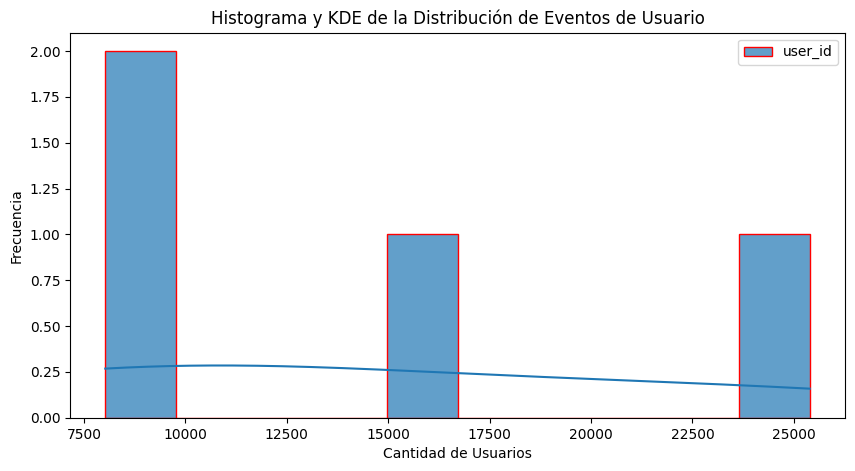

In [31]:
plt.figure(figsize=(10,5))
sns.histplot(eventos_grupoA, kde=True, bins=10, color='blue', edgecolor='red', alpha=0.7)
plt.title("Histograma y KDE de la Distribución de Eventos de Usuario")
plt.xlabel("Cantidad de Usuarios")
plt.ylabel("Frecuencia")
plt.show()


#### **Comentario:** 

- En este caso, los datos están desbalanceados, lo que sugiere que no siguen una distribución normal.

In [32]:
eventos_grupoB = participantes_eventos.groupby(['event_name', 'group']).agg({'user_id':'count'}).reset_index().query('group == "B"')

display(eventos_grupoB)

,event_name,group,user_id
1,login,B,19311
3,product_cart,B,6295
5,product_page,B,12292
7,purchase,B,6235


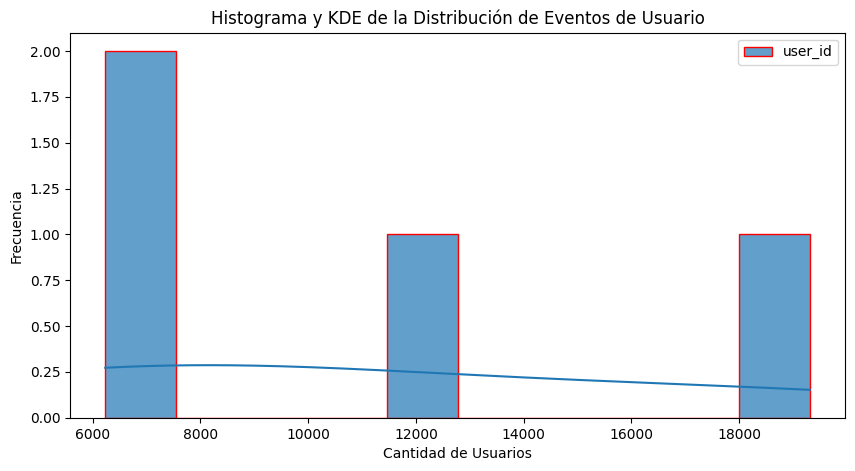

In [33]:
plt.figure(figsize=(10,5))
sns.histplot(eventos_grupoB, kde=True, bins=10, color='blue', edgecolor='red', alpha=0.7)
plt.title("Histograma y KDE de la Distribución de Eventos de Usuario")
plt.xlabel("Cantidad de Usuarios")
plt.ylabel("Frecuencia")
plt.show()

#### **Comentario:** 

- En este caso para el grupo B encontramos el mismo resultado, los datos están desbalanceados, lo que sugiere que no siguen una distribución normal.

### 2.3. ¿Hay usuarios que están presentes en ambas muestras?

In [34]:
# Contar cuántas veces aparece cada user_id en los 2 grupos
duplicados = participantes_eventos.groupby('user_id')['group'].nunique()

# Filtrar los user_id que aparecen en más de un grupo
usuarios_repetidos = duplicados[duplicados > 1]

# Mostrar los user_id duplicados
display(usuarios_repetidos)

user_id
0082295A41A867B5    2
00E68F103C66C1F7    2
02313B9E82255F47    2
04F2CF340B4F3822    2
051D59BC38C3B3AA    2
                   ..
FE2AF0E94DBD470E    2
FE8F9858BBE502D9    2
FEA0C585A53E7027    2
FEC0BCA6C323872F    2
FFF28D02B1EACBE1    2
Name: group, Length: 441, dtype: int64

#### **Comentario:** 

- Encontramos usuarios duplicados en ambas pruebas. La cual procederemos a eliminar ya que son un grupo pequeño mucho menor al 5%.

In [35]:
# Extraer solo los user_id de esa serie en una lista, 

usuarios_repetidos_ids = usuarios_repetidos.index.to_list()

In [36]:
# Filtrar el DataFrame eliminando los user_id presentes en la lista de usuarios_repetidos_ids

participantes_eventos = participantes_eventos[~participantes_eventos['user_id'].isin(usuarios_repetidos_ids)]

display(participantes_eventos)

,user_id,event_dt,event_name,details,group,ab_test
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test
1,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test
2,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,A,interface_eu_test
3,354D653172FF2A2D,2020-12-07 15:45:11,purchase,4.99,A,interface_eu_test
4,7FCD34F47C13A9AC,2020-12-07 22:06:13,purchase,9.99,B,interface_eu_test
...,...,...,...,...,...,...
102833,75845C83258FBF73,2020-12-30 06:42:52,login,0.00,B,recommender_system_test
102834,4584E51B99DE51AE,2020-12-30 07:39:32,login,0.00,A,interface_eu_test
102835,9DF4F595A906A0BA,2020-12-30 18:28:55,login,0.00,B,interface_eu_test
102836,6181F3835EBE66BF,2020-12-30 12:00:00,login,0.00,A,interface_eu_test


### 2.4 ¿Cómo se distribuye el número de eventos entre los días?

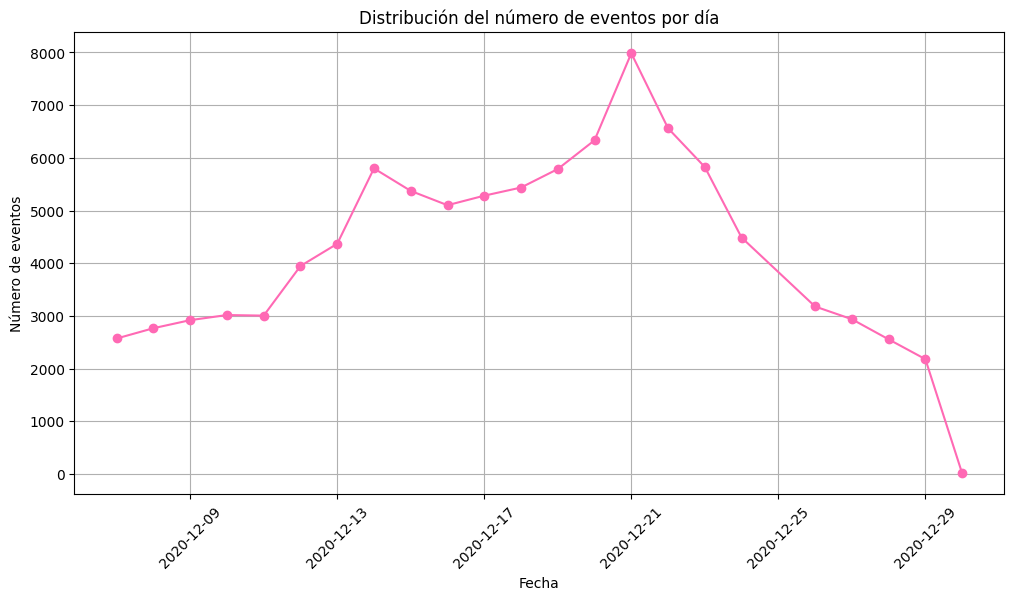

In [37]:
# Convertir columnas a datetime y extraer el dia 

participantes_eventos['event_dt'] = pd.to_datetime(participantes_eventos['event_dt'])
participantes_eventos['event_date'] = participantes_eventos['event_dt'].dt.date

# Contar el número de eventos por día

eventos_por_dia = participantes_eventos.groupby('event_date').size().reset_index(name='event_count')

plt.figure(figsize=(12, 6))
plt.plot(eventos_por_dia['event_date'], eventos_por_dia['event_count'], marker="o", linestyle="-", color="hotpink")
plt.xlabel("Fecha")
plt.ylabel("Número de eventos")
plt.title("Distribución del número de eventos por día")
plt.xticks(rotation=45)
plt.grid()
plt.show()


#### ***Observaciones:***

- La distribución de eventos entre los dias va aumentando con el pasar del tiempo, sin embargo hay dias en lo que se percibe disminución no tan significativa. Vemos un incremento circunstancial entre los dias 20 y 22, pero posterior a esta fecha, disminuye totalmente a hasta llegar a finales del año.

In [38]:
display(participantes_eventos)

,user_id,event_dt,event_name,details,group,ab_test,event_date
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test,2020-12-07
1,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07
2,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,A,interface_eu_test,2020-12-07
3,354D653172FF2A2D,2020-12-07 15:45:11,purchase,4.99,A,interface_eu_test,2020-12-07
4,7FCD34F47C13A9AC,2020-12-07 22:06:13,purchase,9.99,B,interface_eu_test,2020-12-07
...,...,...,...,...,...,...,...
102833,75845C83258FBF73,2020-12-30 06:42:52,login,0.00,B,recommender_system_test,2020-12-30
102834,4584E51B99DE51AE,2020-12-30 07:39:32,login,0.00,A,interface_eu_test,2020-12-30
102835,9DF4F595A906A0BA,2020-12-30 18:28:55,login,0.00,B,interface_eu_test,2020-12-30
102836,6181F3835EBE66BF,2020-12-30 12:00:00,login,0.00,A,interface_eu_test,2020-12-30


### 2.5 ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

#### ***Observaciones:***
    
- Se observo duplicados de user_id en ambas pruebas, lo cual puede afectar la validez del experimento y distorsionar los resultados estadísticos. Razón por la cual dicho duplicados fueron eliminados.
- Pudimos observar que hay la cantidad de productos que se agregan al carrito en el grupo A, es mucho menor que la cantidad de productos comprados.
- En el grupo con el nuevo embudo de pago no sucede esto (Grupo B), la cantidad de productos agregados al carrito si es mayor que la cantidad de productos comprados. Muchos clientes llegan a la etapa de agregar productos al carrito pero no todos terminan concretando una compra.

## 3. Evaluar los resultados de la prueba A/B:

### 3.1 ¿Qué puedes decir sobre los resultados de la prueba A/B?

Podemos observar que el grupo B, en el cual se realizó test bajo el nombre de "recommender_system_test", para la cual se implementó el nuevo sistema de recomendaciones, no hubo el 10% de incremento de usuarios como se esperaba, más bien se denoto un disminición del 28% en las compras para el nuevo embudo de pago. Por lo que el nuevo sistema de recomendaciones no proporcionó el impacto deseado.

### 3.2 Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones

<div class="alert alert-block alert-info">
<b>Hipótesis</b>
<b>Nula (H₀): La nueva estrategia de recomendaciones no tiene un impacto significativo en el numero de compras realizadas por el usuario.
Alternativa (H₁): La nueva estrategia de recomendaciones tiene un impacto significativo en el numero de compras realizadas por el usuario. Nivel de significancia: α = 0.05</b> <a class="tocSkip"></a>
</div>

In [39]:
# Tomamos nuestro Dataframe filtrado las columnas que nos interesa

filtrado_ab = participantes_eventos.loc[:,['event_name','details','group']]

display(filtrado_ab)

,event_name,details,group
0,purchase,4.99,B
1,purchase,4.99,A
2,purchase,4.99,A
3,purchase,4.99,A
4,purchase,9.99,B
...,...,...,...
102833,login,0.00,B
102834,login,0.00,A
102835,login,0.00,B
102836,login,0.00,A


In [40]:
# Filtrar solo el evento purcharse

filtrado_ab = filtrado_ab[filtrado_ab['event_name'].isin(['purchase'])]

display(filtrado_ab)


,event_name,details,group
0,purchase,4.99,B
1,purchase,4.99,A
2,purchase,4.99,A
3,purchase,4.99,A
4,purchase,9.99,B
...,...,...,...
14849,purchase,4.99,A
14850,purchase,4.99,A
14851,purchase,99.99,A
14852,purchase,9.99,A


In [41]:
# Filtramos grupo A

filtrado_groupA = filtrado_ab.query('group == "A"')['details'].reset_index(drop=True) 

display(filtrado_groupA)


0        4.99
1        4.99
2        4.99
3        9.99
4        4.99
        ...  
8263     4.99
8264     4.99
8265    99.99
8266     9.99
8267     4.99
Name: details, Length: 8268, dtype: float64

In [42]:
# Filtramos grupo B

filtrado_groupB = filtrado_ab.query('group == "B"')['details'].reset_index(drop=True) 

display(filtrado_groupB)

0         4.99
1         9.99
2         4.99
3         4.99
4       499.99
         ...  
5879      4.99
5880      4.99
5881      4.99
5882      4.99
5883      9.99
Name: details, Length: 5884, dtype: float64

In [46]:

# Realizar la prueba t de Student

resultado = stats.ttest_ind(filtrado_groupA, filtrado_groupB)

t_statistic, p_value = stats.ttest_ind(filtrado_groupA, filtrado_groupB)

# Resultados

print('Estadística t:', t_statistic)
print('Valor p:', p_value)

# Interpretar los resultados

alpha = 0.05

if p_value < alpha:
    print("Rechazamos la hipótesis nula: La nueva estrategia de recomendaciones tiene un impacto significativo en el número de compras realizadas por los usuarios.")
else:
    print("No podemos rechazar la hipótesis nula: No hay suficiente evidencia estadística para concluir que la nueva estrategia de recomendaciones haya tenido un impacto significativo en el número de compras realizadas por los usuarios.")


Estadística t: 0.3877933199394117
Valor p: 0.6981748225645008
No podemos rechazar la hipótesis nula: No hay suficiente evidencia estadística para concluir que la nueva estrategia de recomendaciones haya tenido un impacto significativo en el número de compras realizadas por los usuarios.


## 4. Conclusiones:

**Distribución de eventos:** 

- La cantidad de eventos por usuario en ambos grupos (A/B) no sigue una distribución equitativa.

**Declive en la actividad:** 

- A partir del 23/12, se observa una disminución significativa en la cantidad de eventos registrados.
  
**Usuarios duplicados:** 

- Se identificaron usuarios que participaron en ambos grupos. Sin embargo, al representar menos del 5% del total, su exclusión en el análisis no afecta significativamente la validez de los resultados.

#### - Impacto del nuevo sistema de recomendaciones:

- No se alcanzó el aumento del 10% esperado en las compras.
  
- Por el contrario, se registró una disminución del 28% en las compras con el nuevo embudo de pago. Esto indica que el nuevo sistema de recomendaciones no tuvo el impacto positivo esperado.
  
- Sin embargo con nuestra prueba de hipótesis pudimos confirmar, que no hay suficiente evidencia estadística para concluir que la nueva estrategia de recomendaciones haya tenido un impacto significativo en el número de compras realizadas por los usuarios.

- El nuevo sistema de recomendaciones no mostró un impacto esperado en las compras. No significa que no funcione, sino que no tenemos evidencia sólida para afirmarlo.

- Los resultados obtenidos no son los suficientemente relevantes como para considerar que el nuevo sistema de recomendaciones sea la mejor opción para se pueda dar un incremento.

- Es posible que se necesiten más datos o un ajuste en la estrategia para medir mejor su efecto.